Random Seed:  999


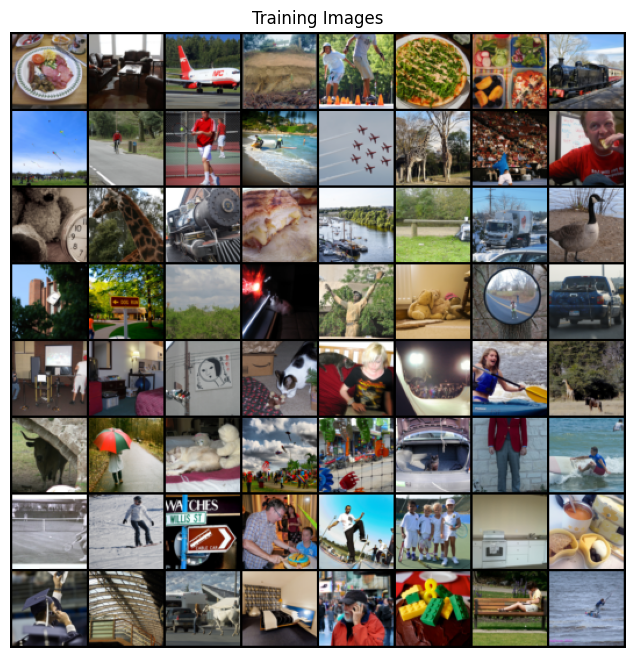

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

/tmp/ipykernel_30/3085495657.py:212: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(path_generator))
/tmp/ipykernel_30/3085495657.py:213: Futu

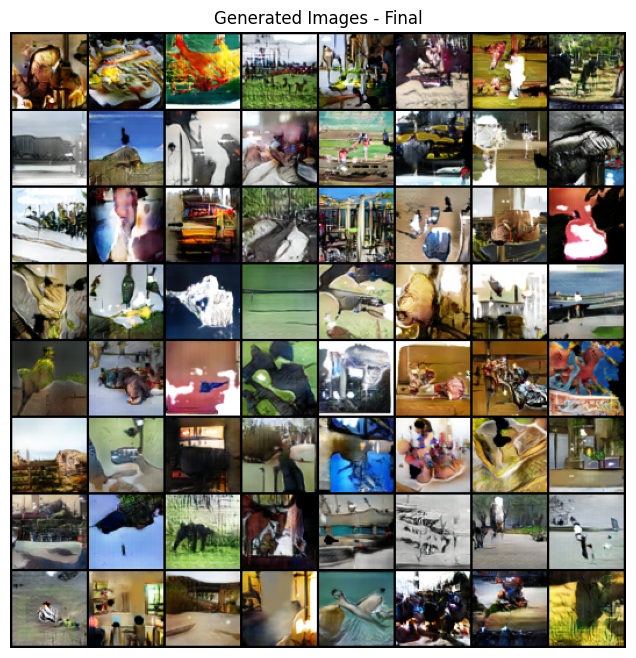

Final generated images saved to final_generated_images.png


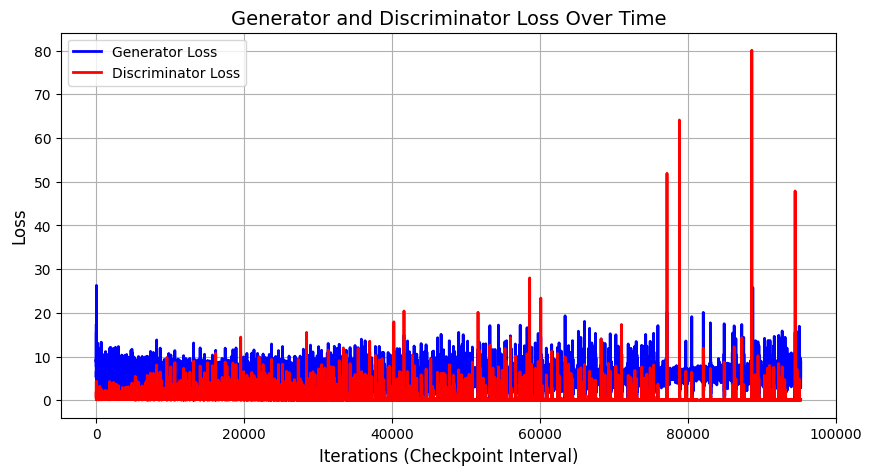

Loss plot saved to loss_plot.png


In [31]:
#FUNZIONANTE DA CONSEGNARE
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image  # Importa PIL per il caricamento delle immagini

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)  # Necessario per risultati riproducibili

# Root directory for dataset
dataroot = "/kaggle/input/coco-2017-dataset/coco2017/train2017"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100  # Aumenta il numero di epoche se necessario

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

# Imposta i percorsi per i checkpoint
checkpoint_path_generator = 'checkpoint_generator.pth'
checkpoint_path_discriminator = 'checkpoint_discriminator.pth'
checkpoint_path_epoch = 'checkpoint_epoch.pth'
losses_path = 'losses.npy'

path_generator = '/kaggle/input/100/pytorch/default/1/checkpoint_generator.pth'
path_discriminator = '/kaggle/input/100/pytorch/default/1/checkpoint_discriminator.pth'
path_epoch = '/kaggle/input/100/pytorch/default/1/checkpoint_epoch.pth'
l_path = '/kaggle/input/100/pytorch/default/1/losses-6.npy'
# Imposta l'intervallo di checkpoint
checkpoint_interval = 10

# Custom dataset class for loading images from a directory
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Create the dataset
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = CustomImageDataset(root_dir=dataroot, transform=transform)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))
plt.show()

# Custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)

# Print the model
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
netD.apply(weights_init)

# Print the model
print(netD)

# Initialize the BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Carica i checkpoint se esistono
if os.path.exists(path_generator) and os.path.exists(path_discriminator) and os.path.exists(path_epoch):
    print("Caricamento dei checkpoint...")
    netG.load_state_dict(torch.load(path_generator))
    netD.load_state_dict(torch.load(path_discriminator))
    start_epoch = torch.load(path_epoch)
    # Carica anche le perdite se disponibili
    if os.path.exists(l_path):
        losses = np.load(l_path, allow_pickle=True).item()
        g_losses = losses['g_losses']
        d_losses = losses['d_losses']
    else:
        g_losses = []
        d_losses = []
    print(f"Ripristino dell'addestramento dall'epoca {start_epoch}...")
else:
    start_epoch = 0
    g_losses = []
    d_losses = []

# Training Loop
print("Inizio del ciclo di addestramento...")
for epoch in range(start_epoch, num_epochs):
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()  # Zero the gradients for D
        real_cpu = data.to(device)  # Load real images to device
        b_size = real_cpu.size(0)  # Get batch size
        label = torch.full((b_size,), real_label, device=device)  # Create labels for real images

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)  # Calculate the loss on real images
        errD_real.backward()  # Backpropagate the loss
        D_x = output.mean().item()  # Get the mean output for logging

        # Generate fake image batch with G
        noise = torch.randn(b_size, nz, 1, 1, device=device)  # Generate noise
        fake = netG(noise)  # Generate fake images
        label.fill_(fake_label)  # Create labels for fake images

        # Forward pass fake batch through D
        output = netD(fake.detach()).view(-1)  # Detach to avoid affecting gradients of G
        errD_fake = criterion(output, label)  # Calculate the loss on fake images
        errD_fake.backward()  # Backpropagate the loss
        D_G_z1 = output.mean().item()  # Get the mean output for logging
        errD = errD_real + errD_fake  # Total loss for D
        optimizerD.step()  # Update D

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()  # Zero the gradients for G
        label.fill_(real_label)  # Real labels for generator
        output = netD(fake).view(-1)  # Forward pass fake images through D
        errG = criterion(output, label)  # Calculate the loss for G
        errG.backward()  # Backpropagate the loss
        D_G_z2 = output.mean().item()  # Get the mean output for logging
        optimizerG.step()  # Update G
        g_losses.append(errG.item())
        d_losses.append(errD.item())
        # Print log info
        if i % 50 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item()} Loss_G: {errG.item()} D(x): {D_x} D(G(z)): {D_G_z1} / {D_G_z2}")

    
    np.save(losses_path, {'g_losses': g_losses, 'd_losses': d_losses})
    print(f"Perdite salvate su {losses_path}.")
    # Salva i generator e discriminator
    if (epoch + 1) % checkpoint_interval == 0:
        torch.save(netG.state_dict(), checkpoint_path_generator)
        torch.save(netD.state_dict(), checkpoint_path_discriminator)
        torch.save(epoch + 1, checkpoint_path_epoch)  # Salva l'epoca corrente
        print(f"Modelli salvati dopo {epoch + 1} epoche.")
        
        # Salva le perdite su un file

        np.save(losses_path, {'g_losses': g_losses, 'd_losses': d_losses})
        print(f"Perdite salvate su {losses_path}.")

        # Genera e visualizza immagini ogni 10 epoche
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            plt.figure(figsize=(8,8))
            plt.axis("off")
            plt.title(f"Generated Images at Epoch {epoch + 1}")
            plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1,2,0)))
            plt.show()

# Salva i modelli finali
torch.save(netG.state_dict(), checkpoint_path_generator)
torch.save(netD.state_dict(), checkpoint_path_discriminator)
torch.save(num_epochs, checkpoint_path_epoch)  # Salva l'epoca finale
print("Modelli finali salvati.")

# Visualizza i risultati finali e salva il grafico delle perdite
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images - Final")
    plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1, 2, 0)))
    
    # Save the final generated images before showing
    final_image_path = "final_generated_images.png"
    plt.savefig(final_image_path, bbox_inches='tight')  # Save the image
    plt.show()  # Then show the image
    print(f"Final generated images saved to {final_image_path}")

# Plot and save the loss curves
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss', color='blue', linewidth=2)  # Thicker line for better visibility
plt.plot(d_losses, label='Discriminator Loss', color='red', linewidth=2)  # Thicker line for better visibility
plt.xlabel('Iterations (Checkpoint Interval)', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Generator and Discriminator Loss Over Time', fontsize=14)
plt.legend()
plt.grid()
loss_plot_path = "loss_plot.png"
plt.savefig(loss_plot_path, bbox_inches='tight')  # Save the plot
plt.show()  # Show the plot
print(f"Loss plot saved to {loss_plot_path}")


In [10]:
#GENERATORE GAN IMMAGINI 
import torch
import os
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Definisci i parametri utilizzati per l'addestramento
nz = 100  # Dimensione del vettore latente z
ngf = 64  # Feature maps nel generatore
nc = 3    # Numero di canali dell'immagine (3 per immagini RGB)
ngpu = 2  # Numero di GPU
num_images = 2000

# Carica il generatore
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Inizializza il generatore
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
netG = Generator(ngpu).to(device)

# Carica i pesi del generatore salvato
checkpoint_path_generator = '/kaggle/input/100/pytorch/default/1/checkpoint_generator.pth'
checkpoint = torch.load(checkpoint_path_generator)

# Se i pesi sono stati salvati con DataParallel, rimuovi 'module.' dai nomi
if 'module.' in list(checkpoint.keys())[0]:
    checkpoint = {k.replace('module.', ''): v for k, v in checkpoint.items()}

netG.load_state_dict(checkpoint)

# Se hai più GPU, usa DataParallel
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    
# Crea la cartella per salvare le immagini
output_folder = '/kaggle/working/generated_images'
os.makedirs(output_folder, exist_ok=True)

# Genera e salva le immagini
with torch.no_grad():
    for i in range(num_images):
        fixed_noise = torch.randn(1, nz, 1, 1, device=device)  # Vettore di rumore
        fake = netG(fixed_noise).detach().cpu()

        # Salva l'immagine
        image_path = os.path.join(output_folder, f'generated_image_{i + 1}.png')
        vutils.save_image(fake, image_path, normalize=True)

print(f"Generated and saved {num_images} images in {output_folder}.")


/tmp/ipykernel_30/3056831037.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path_generator)


Generated and saved 2000 images in /kaggle/working/generated_images.


In [11]:
import shutil

# Specifica il percorso della cartella che vuoi comprimere
folder_to_zip = '/kaggle/working/generated_images'  # Sostituisci con il percorso della tua cartella
output_zip = '/kaggle/working/output_folder.zip'

# Crea un file ZIP della cartella
shutil.make_archive(folder_to_zip, 'zip', folder_to_zip)

'/kaggle/working/generated_images.zip'